# Checkbox Labeling  

Author(s) - Ryan Folks  
Purpose - To label checkboxes using the position of checkboxes.  

---

## 0 - Problem

### 0.0 - Checkboxes on the Chart

Checkboxes on the chart encode binary information. The absence of a check indicate a false state, and any sort of marking in the checkbox indicates a true state.  

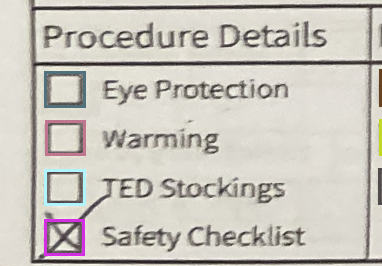

In order to leverage the fact that all checkboxes are identical from a visual perspective (that is, that the box which is to the left of 'Eye Protection' is identical to the one next to 'TED Stockings', all checkboxes are labeled as one of two classes: {'checked', 'unchecked'}.  

This has allowed a small number of charts to supply thousands of checkbox datapoints to train on, which allows the model which identifies and classifies checkboxes to attain a high level of accuracy on only a small number of charts.  
However, this has merely deffered the more important component of checkbox data extraction: the associated meaning of the checkbox.  

For example, in the image above, the model will merely locate four boxes, three of which are unchecked and one of which is checked. In terms of data structures, we are interested in knowing the string which should index a checked or unchecked value in a mapping between box names and values.

### 0.1 - Proposed Solution

Because the homography correction is so good at relocating landmarks to within a very small neighborhood of the scanned, perfect image, a combination of a clustering algorithm along with a simple distance 'sanity' check should do quite well in associating meaning with checkboxes.

## 1 - Load Data

### 1.0 - Import Packages

In [1]:
import sys
import os
sys.path.append(os.path.join("..", "..", "..", "ChartExtractor", "src"))

In [2]:
import json
import random
from PIL import Image, ImageDraw
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm import tqdm
from utilities.annotations import BoundingBox, Point
from utilities.image_conversion import pil_to_cv2, cv2_to_pil
import cv2
import numpy as np
import pandas as pd
from operator import attrgetter

In [3]:
Point.__repr__ = lambda self: f"Point({self.x}, {self.y})" # todo: add a repr method to Point.

---

### 1.1 Import & Wrangle Data

In [4]:
def label_studio_to_bboxes(path_to_json_data: Path) -> List[BoundingBox]:
    json_data: List[Dict] = json.loads(open(str(path_to_json_data)).read())
    return {
        sheet_data['data']['image'].split("-")[-1]:[
            BoundingBox(
                category=label['value']['rectanglelabels'][0],
                left=label['value']['x']/100,
                top=label['value']['y']/100,
                right=label['value']['x']/100+label['value']['width']/100,
                bottom=label['value']['y']/100+label['value']['height']/100,
            )
            for label in sheet_data['annotations'][0]['result']
        ]
        for sheet_data in json_data
    }


data_path: Path = Path("..")/".."/"data"
landmark_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_document_landmarks.json")
checkbox_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_checkbox_names.json")

Here we create a *slightly* different version of the homography function.  
The only difference here is that the function returns the homography matrix along with the homographied image.

In [5]:
def homography_transform(
    src_image: Image.Image,
    src_points: List[Tuple[float, float]],
    dest_points: List[Tuple[float, float]],
    original_image_size: Tuple[float, float] = (3300, 2250),
) -> Tuple[List[List[float]], Image.Image]:
    """Performs homography transformation on an image.

    This function transforms an image (src_image) based on corresponding points
    between the source and destination images. It calculates the homography matrix
    and uses it to warp the source image to the perspective of the destination points.

    Args:
        src_image (Image.Image):
            A PIL image object representing the source image.
        src_points (List[Tuple[int, int]]):
            A list of tuples (x, y) representing points in the source image that correspond
            to points in the destination image.
        dest_points (List[Tuple[int, int]]):
            A list of tuples (x, y) representing points in the destination image that points
            in the source image correspond to (where the source image should be warped to).
        original_image_size (Tuple[float, float]):
            A tuple (width, height) representing the size of the control image.
            Defaults to (3300, 2250).

    Returns:
        A PIL image object representing the transformed source image.

    Raises:
        ValueError:
            If the length of src_points and dest_points don't match (must have the same
            number of corresponding points), or if there are less than 4 points.
    """
    src_points: np.ndarray = np.array(src_points)
    dest_points: np.ndarray = np.array(dest_points)

    if len(src_points) != len(dest_points):
        raise ValueError(
            "Source and destination points must have the same number of elements."
        )
    if len(src_points) < 4 or len(dest_points) < 4:
        raise ValueError("Must have 4 or more points to compute the homography.")

    src_image = pil_to_cv2(src_image)
    h, _ = cv2.findHomography(src_points, dest_points)
    dest_image = cv2.warpPerspective(src_image, h, original_image_size)
    return h, cv2_to_pil(dest_image)

In [6]:
sorted(landmark_location_data['unified_intraoperative_preoperative_flowsheet_v1_1_front.png'], key=lambda bb: bb.category)

[BoundingBox(category='anesthesia_start', left=0.01272509471128841, top=0.0074461197571953, right=0.07575473602069113, bottom=0.016866305933318605),
 BoundingBox(category='lateral', left=0.8478774710612861, top=0.9807845444628994, right=0.8745474031974078, bottom=0.9901969156805276),
 BoundingBox(category='safety_checklist', left=0.030913069333097596, top=0.980779480372136, right=0.09272854168786186, bottom=0.9925825938048181),
 BoundingBox(category='units', left=0.9460597274343558, top=0.029801815290808963, right=0.9706124622802825, bottom=0.04156358205163003)]

In [7]:
def get_corresponding_points(
    bboxes: List[BoundingBox], 
    imsize: Tuple[int, int],
    categories_to_get: List[str] = ['anesthesia_start', 'lateral', 'safety_checklist', 'units']
):
    """Gets the 'anesthesia_start', 'lateral', 'safety_checklist', and 'units' checkboxes
    from the list of bboxes.

    Args:
        bboxes (List[BoundingBox]):
            All the checkbox bounding boxes labeled by the name of the box they indicate.
        imsize (Tuple[int, int]):
            The size of the image.

    Returns:
        A list of tuples corresponding to the points 'anesthesia_start', 'lateral', 
        'safety_checklist', and 'units' BoundingBox centers. The list is sorted
        by the category names to maintain consistency.
    """
    points = list(map(
        attrgetter('center'),
        sorted(
            list(filter(lambda bb: bb.category in categories_to_get, bboxes)), 
            key=lambda bb: bb.category
        )
    ))
    return [(p[0]*imsize[0], p[1]*imsize[1]) for p in points]

In [8]:
sheet = "RC_0001_intraoperative.JPG"
img = Image.open(str(data_path/"chart_images"/sheet))
h, transformed_img = homography_transform(
    img, 
    get_corresponding_points(landmark_location_data[sheet], img.size),
    get_corresponding_points(landmark_location_data["unified_intraoperative_preoperative_flowsheet_v1_1_front.png"], (3300, 2250)),
)

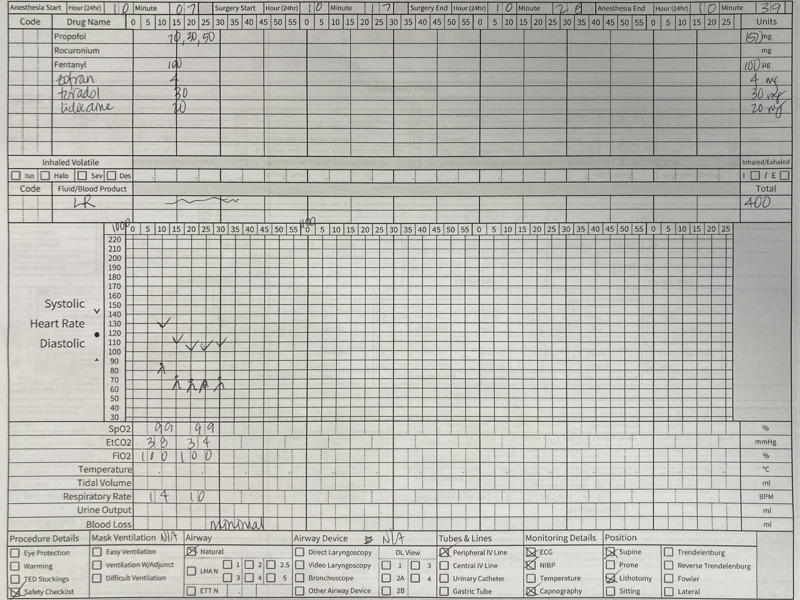

In [9]:
transformed_img.resize((800, 600))

Helpful functions for remapping new points using the homography matrix.

In [10]:
remap_point = lambda p, h: cv2.perspectiveTransform(np.array(p, dtype=np.float32).reshape(-1, 1, 2), h).tolist()[0][0]


def remap_bbox(
    bbox: BoundingBox, 
    h, 
    original_width:int=4032, 
    original_height:int=3024,
    new_width:int=3300,
    new_height:int=2250,
) -> BoundingBox:
    """Applys the remap_point function to a BoundingBox.

    Args:
        bbox (BoundingBox):
            The bounding box to apply the homography to.
        h (np.ndarray):
            The homography matrix.
        original_width (int):
            The width of the original image.
        original_height (int):
            The height of the original image.
        new_width (int):
            The width of the destination image.
        new_height (int):
            The height of the destination image.

    Returns:
        A BoundingBox that has been remapped to the new image via the homography matrix.
    """
    new_left, new_top = remap_point((bbox.left*original_width, bbox.top*original_height), h)
    new_right, new_bottom = remap_point((bbox.right*original_width, bbox.bottom*original_height), h)
    return BoundingBox(bbox.category, new_left/new_width, new_top/new_height, new_right/new_width, new_bottom/new_height)


remap_all_bboxes = lambda bboxes, h: [remap_bbox(bb, h) for bb in bboxes]


locations = landmark_location_data[sheet]
remapped_locations = remap_all_bboxes(locations, h)

Get landmarks that show up only once.

Check labels.

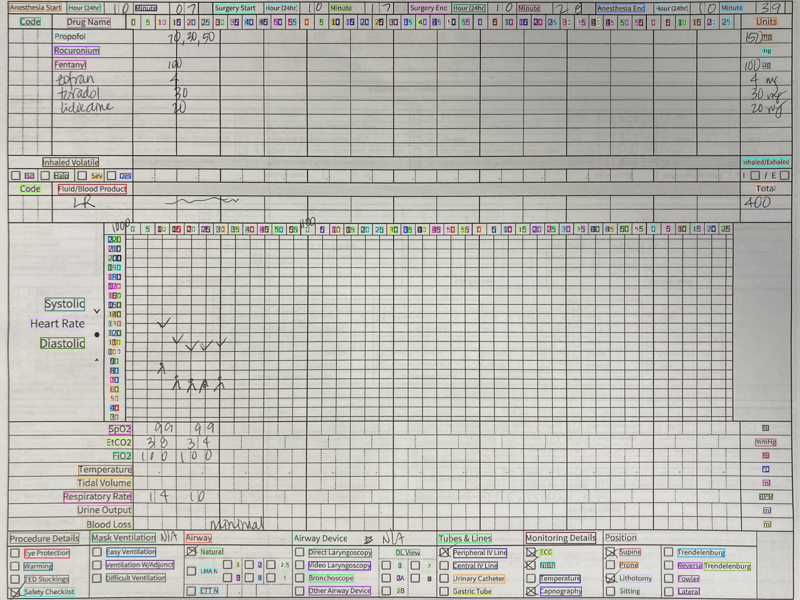

In [11]:
generate_color = lambda: "#%06x" % random.randint(0, 0xFFFFFF)

sheet = "RC_0001_intraoperative.JPG"
img = Image.open(str(data_path/"chart_images"/sheet))
original_width, original_height = img.size
img = transformed_img.copy()
width, height = img.size
draw = ImageDraw.Draw(img)

for bounding_box in remapped_locations:
    box = [
        bounding_box.left*width,
        bounding_box.top*height,
        bounding_box.right*width,
        bounding_box.bottom*height,
    ]
    draw.rectangle(box, outline=generate_color(), width=3)
img.resize((800, 600))

Remap all data

In [12]:
landmark_names = [bb.category for bb in landmark_location_data["RC_0001_intraoperative.JPG"]]
singleton_landmark_names = list(filter(lambda bb_name: landmark_names.count(bb_name) == 1, landmark_names))
singleton_landmark_location_data = {
    k:list(filter(lambda bb: bb.category in singleton_landmark_names, v))
    for (k, v) in landmark_location_data.items()
}

In [13]:
remapped_data = dict()
remapped_checkboxes = dict()
for im_name, boxes in tqdm(singleton_landmark_location_data.items()):
    if im_name=="unified_intraoperative_preoperative_flowsheet_v1_1_front.png":
        continue
    img = Image.open(str(data_path/"chart_images"/im_name))
    h, transformed_img = homography_transform(
        img, 
        get_corresponding_points(boxes, img.size),
        get_corresponding_points(singleton_landmark_location_data["unified_intraoperative_preoperative_flowsheet_v1_1_front.png"], (3300, 2250)),
    )
    remapped_boxes = remap_all_bboxes(boxes, h)
    try:
        remapped_cboxs = remap_all_bboxes(checkbox_location_data[im_name], h)
    except:
        pass
    remapped_data[im_name] = remapped_boxes
    remapped_checkboxes[im_name] = remapped_cboxs

100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


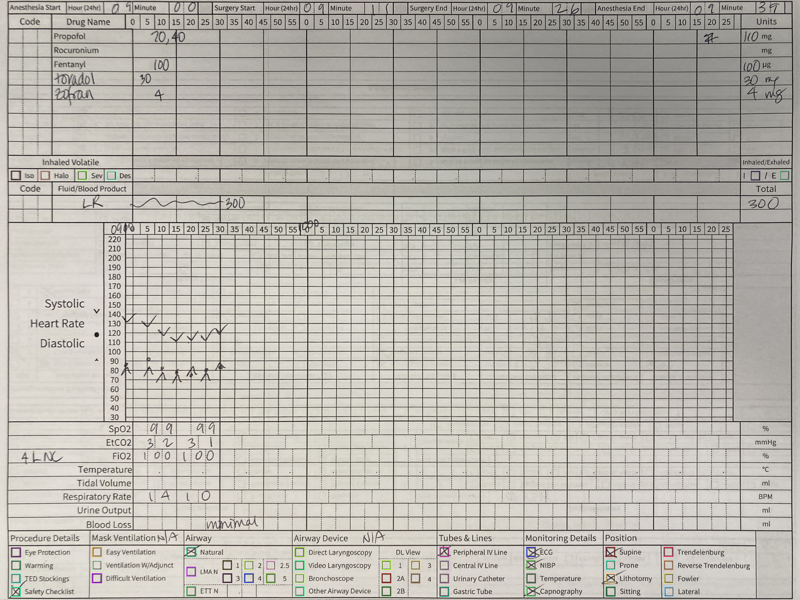

In [14]:
sheet = "RC_0005_intraoperative.JPG"
img = Image.open(str(data_path/"chart_images"/sheet))


_, img = homography_transform(
    img, 
    get_corresponding_points(landmark_location_data[sheet], img.size), 
    get_corresponding_points(landmark_location_data["unified_intraoperative_preoperative_flowsheet_v1_1_front.png"], (3300, 2250))
)
original_width, original_height = img.size
width, height = img.size
draw = ImageDraw.Draw(img)

for bounding_box in remapped_checkboxes[sheet]:
    box = [
        bounding_box.left*width,
        bounding_box.top*height,
        bounding_box.right*width,
        bounding_box.bottom*height,
    ]
    draw.rectangle(box, outline=generate_color(), width=3)
img.resize((800, 600))

## 2 - Investingating Clustering

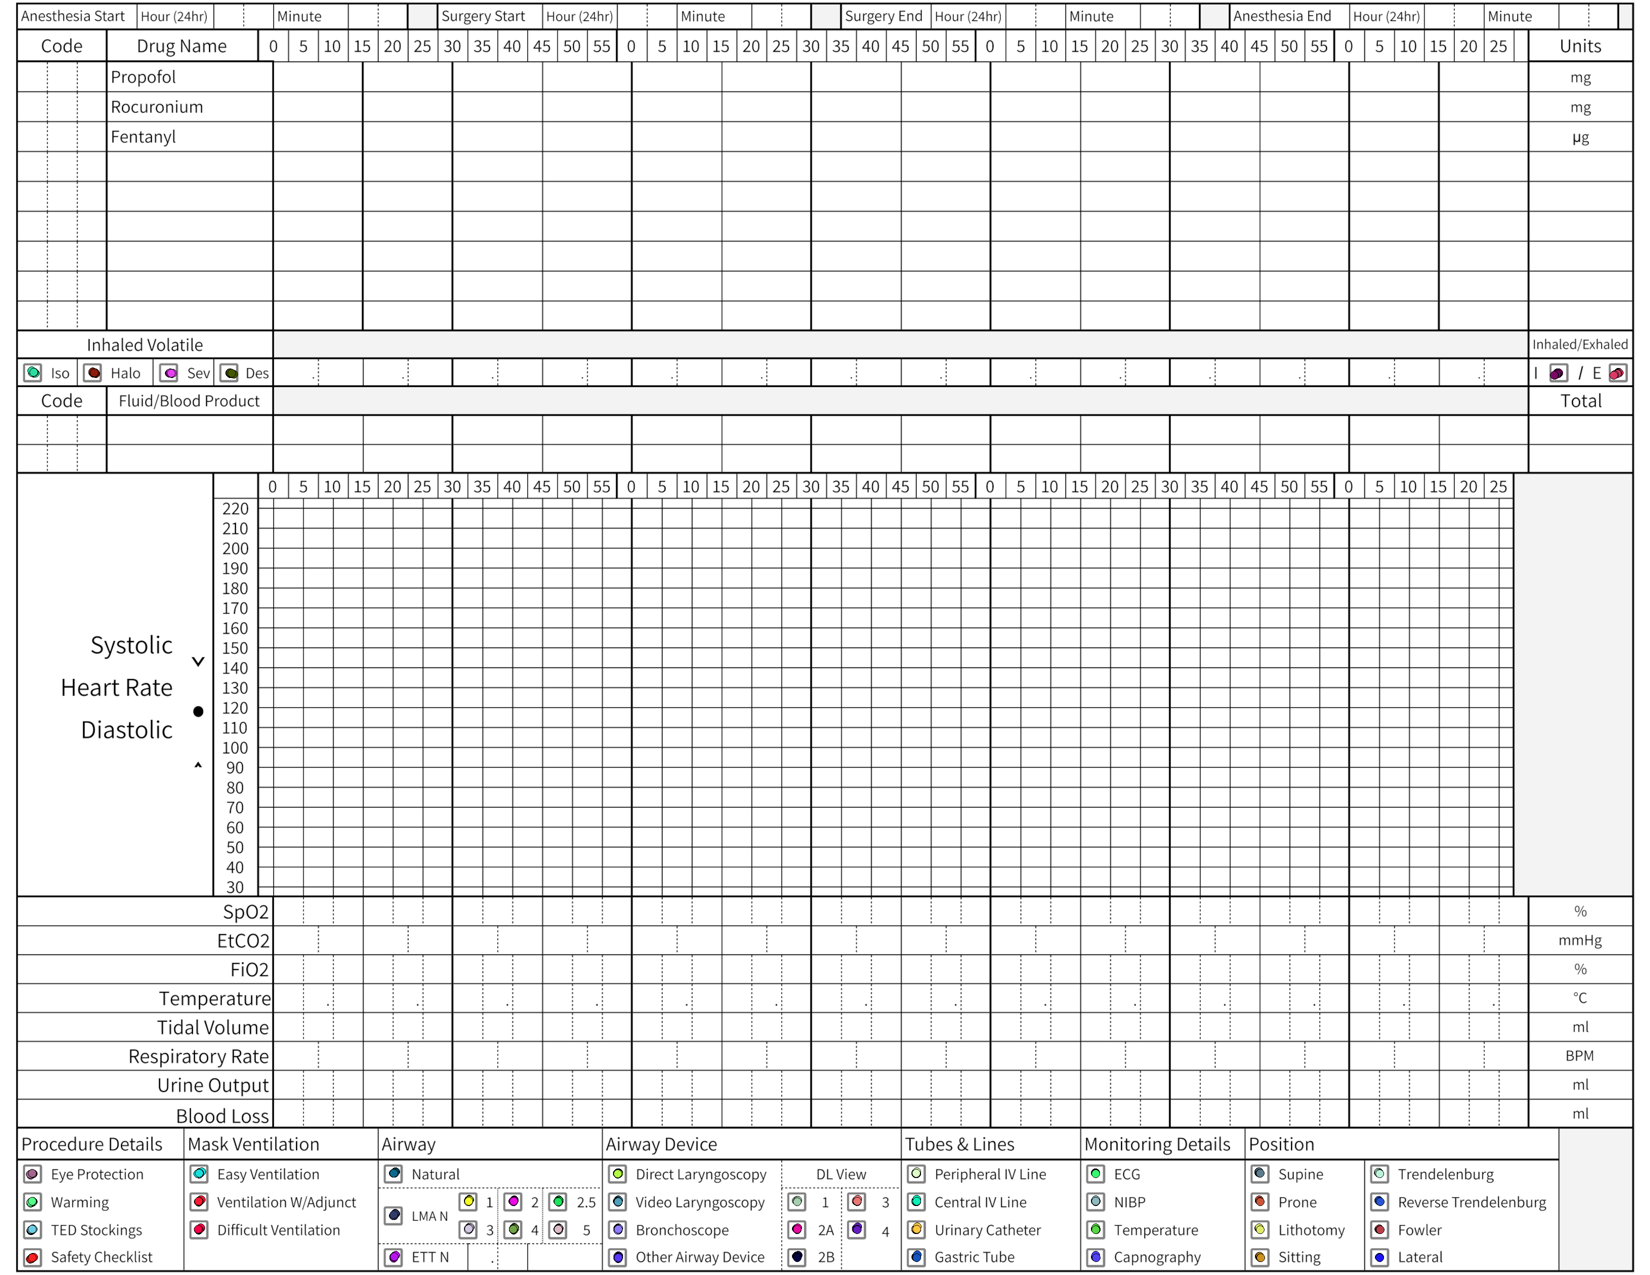

In [15]:
all_checkboxes_list = [item for sublist in [v for v in remapped_checkboxes.values()] for item in sublist]
checkbox_names = list(set([bb.category for bb in all_checkboxes_list]))
checkbox_name_to_color_map = {name:generate_color() for name in checkbox_names}

WIDTH, HEIGHT = 3300, 2250
im = Image.new(mode="RGB", size=(WIDTH, HEIGHT), color='white')
im = Image.open(data_path/"unified_intraoperative_preoperative_flowsheet_v1_1_front.png")
WIDTH, HEIGHT = im.size
draw = ImageDraw.Draw(im)
POINT_SIZE = 8
for checkbox in all_checkboxes_list:
    x, y = checkbox.center
    x, y = x*WIDTH, y*HEIGHT
    draw.ellipse(
        (x-POINT_SIZE, y-POINT_SIZE, x+POINT_SIZE, y+POINT_SIZE),
        fill=checkbox_name_to_color_map[checkbox.category],
        outline="black"
    )
im.resize((WIDTH//2, HEIGHT//2))

From this we can see that the checkboxes remain in almost the exact same location.  
While this may suggest that we can merely do a check for a range of values, I would prefer to future proof this slightly against sheets that have been folded/unfolded, and might have a little more variance. 

In [16]:
from sklearn.cluster import KMeans

In [17]:
checkbox_clusterer = KMeans(n_clusters=47, n_init="auto", random_state=0).fit(np.array([ckbx.center for ckbx in all_checkboxes_list]))

C:\Users\vcz2aj\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [18]:
name_to_cluster_id_map = {
    v:k
    for (k, v) in list(set(
        sorted(
            [
                (cluster, box.category) 
                for (cluster, box) in list(zip(checkbox_clusterer.labels_.tolist(), all_checkboxes_list))
            ], key=lambda l: l[0]
        )
    ))
}
cluster_id_to_name_map = {v:k for (k, v) in name_to_cluster_id_map.items()}

In [19]:
for box in tqdm(all_checkboxes_list):
    prediction = checkbox_clusterer.predict([np.array(box.center)])
    true = name_to_cluster_id_map[box.category]
    if prediction != true:
        print("ERROR")
        print(box.category)
        print(f"Predicted: {prediction[0]}")
        print(f"True: {true}")

100%|██████████| 893/893 [00:49<00:00, 18.17it/s]


K means makes no errors, but it is slow.  
What will work the same and be much faster is just computing the distance between a new point and the centroid of the observed clusters, which will be implemented later on.

## 3 - Filtering Erronous Detections

Erronous detections are detections that are not truly a checkbox.  
A simple "If detection is X percent away from the normal range" should suffice without getting into fussy novelty detection models.  

In [20]:
category_to_boxes_map = {
    category:list(filter(lambda ckbx: ckbx.category==category, all_checkboxes_list))
    for category in list(set(c.category for c in all_checkboxes_list))
}
centers = {
    category:[box.center for box in category_boxes]
    for (category, category_boxes) in category_to_boxes_map.items()
}
intraop_centroids = {
    category:(np.mean([c[0] for c in centers]), np.mean([c[1] for c in centers]))
    for (category, centers) in centers.items()
}

In [22]:
intraop_centroids

{'nibp': (0.6640051736786033, 0.9419880870796785),
 'direct_laryngoscopy': (0.3745175389924118, 0.9203751713267544),
 'ventilation_w_adjunct': (0.12079679327908506, 0.942004126119335),
 'exhaled': (0.9793098082230612, 0.2934645839044226),
 'peripheral_iv_line': (0.5554011615953947, 0.9201863778097589),
 'dl_view_3': (0.5193791069748679, 0.9420278662966008),
 'lma_2_5': (0.3384455504105611, 0.9422331728572736),
 'video_laryngoscopy': (0.37457361443381193, 0.9422279131259138),
 'eye_protection': (0.019497888616777873, 0.9205752381441886),
 'lateral': (0.8362091580380284, 0.9863633183707967),
 'capnography': (0.6641874556107953, 0.9861761067708332),
 'fowler': (0.8361551959510815, 0.964258355034722),
 'dl_view_1': (0.4830675471304328, 0.9421592653508772),
 'ecg': (0.6639942535449063, 0.9202395547788742),
 'bronchoscope': (0.374580735202041, 0.9640837873492324),
 'sitting': (0.763657800896506, 0.986135959201389),
 'lma_n': (0.23891669071081917, 0.9526501165021931),
 'lma_2': (0.31128883617

The above are the centroids of each checkbox based on a sample of 10 post-homography charts.  
The centroids are based on percentages of image width and height, so (0.25, 0.75) would be 25% across the image and 75% down the image.

In [23]:
def is_erroneous_detection(
    checkbox_center:Tuple[float, float], 
    centroids: Dict[str, Tuple[float, float]],
    threshold: float=0.05
) -> bool:
    """Determines if the new point is outside the range of any checkbox centroid.

    Args:
        checkbox (Tuple[float, float]):
            The checkbox's center.
        threshold (float):
            The threshold of distance from a known checkbox centroid to determine if a
            detection is a true detection. If a point is more than threshold% away from
            a known centroid, it is determined to be an erroneous detection.

    Returns:
        Whether a new point is likely erroneous.
    """
    x: float = checkbox_center[0]
    y: float = checkbox_center[1]
    def point_in_bounds(centroid): 
        return np.sqrt((centroid[0]-x)**2 + (centroid[1]-y)**2) <= threshold
    
    return not any(point_in_bounds(centroid) for centroid in list(centroids.values()))

In [24]:
for box in all_checkboxes_list:
    if is_erroneous_detection(box.center, intraop_centroids):
        print("!!!")

No output of the above cell means that no detection that was observed in the true sample was determined to be erronous.

## 4 - Preoperative Checkboxes

The preoperative checkboxes are slightly more densely packed, meaning there is a higher chance for misclassification.  
In this section, the same methodology will be applied to the checkboxes.  

In [25]:
data_path: Path = Path("..")/".."/"data"
landmark_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"preoperative_document_landmarks.json")
checkbox_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"preoperative_checkbox_names.json")

In [26]:
categories_to_get = ['patient_profile', 'weight', 'signature', 'disposition']
sheet = "RC_0001_preoperative_postoperative.JPG"
img = Image.open(str(data_path/"chart_images"/sheet))
h, transformed_img = homography_transform(
    img, 
    get_corresponding_points(landmark_location_data[sheet], img.size, categories_to_get),
    get_corresponding_points(landmark_location_data["unified_intraoperative_preoperative_flowsheet_v1_1_back.png"], (3300, 2250), categories_to_get),
)

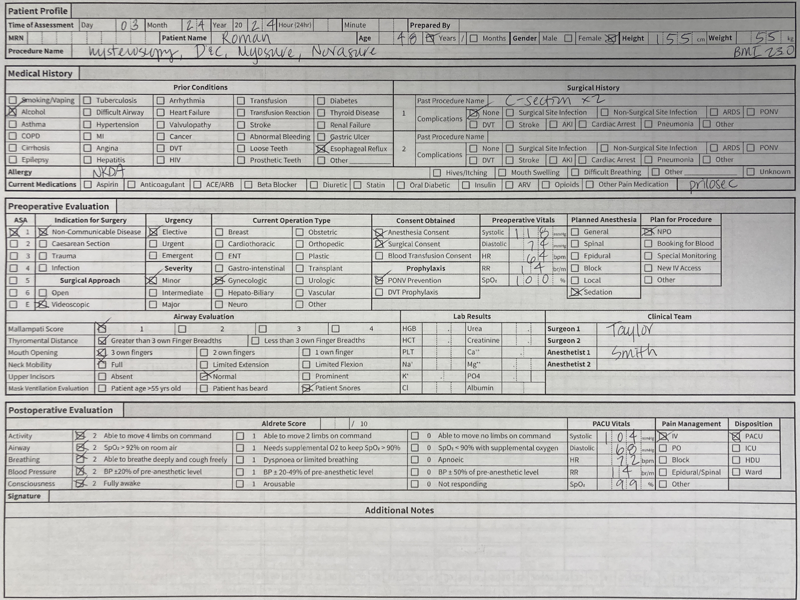

In [27]:
transformed_img.resize((800, 600))

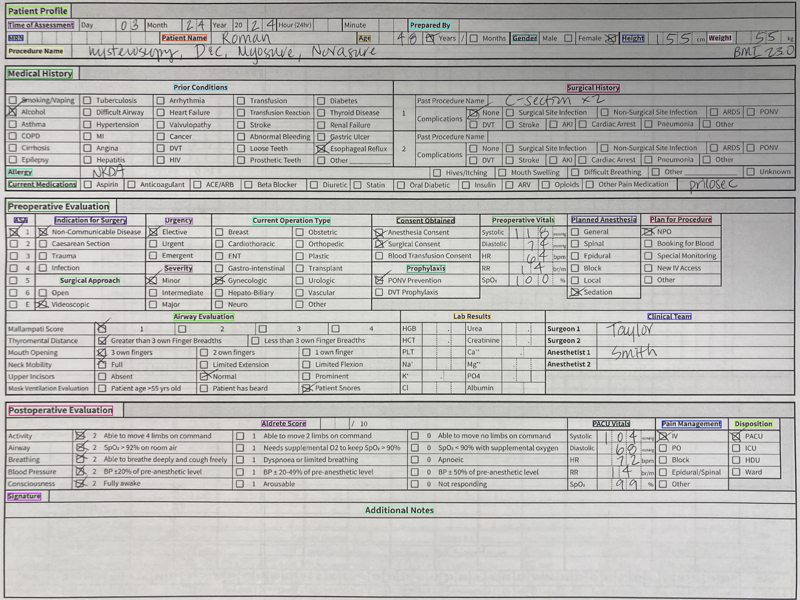

In [28]:
locations = landmark_location_data[sheet]
remapped_locations = remap_all_bboxes(locations, h)

sheet = "RC_0001_preoperative_postoperative.JPG"
img = Image.open(str(data_path/"chart_images"/sheet))
original_width, original_height = img.size
img = transformed_img.copy()
width, height = img.size
draw = ImageDraw.Draw(img)

for bounding_box in remapped_locations:
    box = [
        bounding_box.left*width,
        bounding_box.top*height,
        bounding_box.right*width,
        bounding_box.bottom*height,
    ]
    draw.rectangle(box, outline=generate_color(), width=3)
img.resize((800, 600))

In [29]:
landmark_names = [bb.category for bb in landmark_location_data["RC_0001_preoperative_postoperative.JPG"]]
singleton_landmark_names = list(filter(lambda bb_name: landmark_names.count(bb_name) == 1, landmark_names))
singleton_landmark_location_data = {
    k:list(filter(lambda bb: bb.category in singleton_landmark_names, v))
    for (k, v) in landmark_location_data.items()
}

In [30]:
remapped_data = dict()
remapped_checkboxes = dict()
for im_name, boxes in tqdm(singleton_landmark_location_data.items()):
    if im_name=="unified_intraoperative_preoperative_flowsheet_v1_1_back.png":
        continue
    img = Image.open(str(data_path/"chart_images"/im_name))
    h, transformed_img = homography_transform(
        img,
        get_corresponding_points(boxes, img.size, categories_to_get),
        get_corresponding_points(singleton_landmark_location_data["unified_intraoperative_preoperative_flowsheet_v1_1_back.png"], (3300, 2250), categories_to_get),
    )
    remapped_boxes = remap_all_bboxes(boxes, h)
    try:
        remapped_cboxs = remap_all_bboxes(checkbox_location_data[im_name], h)
    except:
        pass
    remapped_data[im_name] = remapped_boxes
    remapped_checkboxes[im_name] = remapped_cboxs

100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


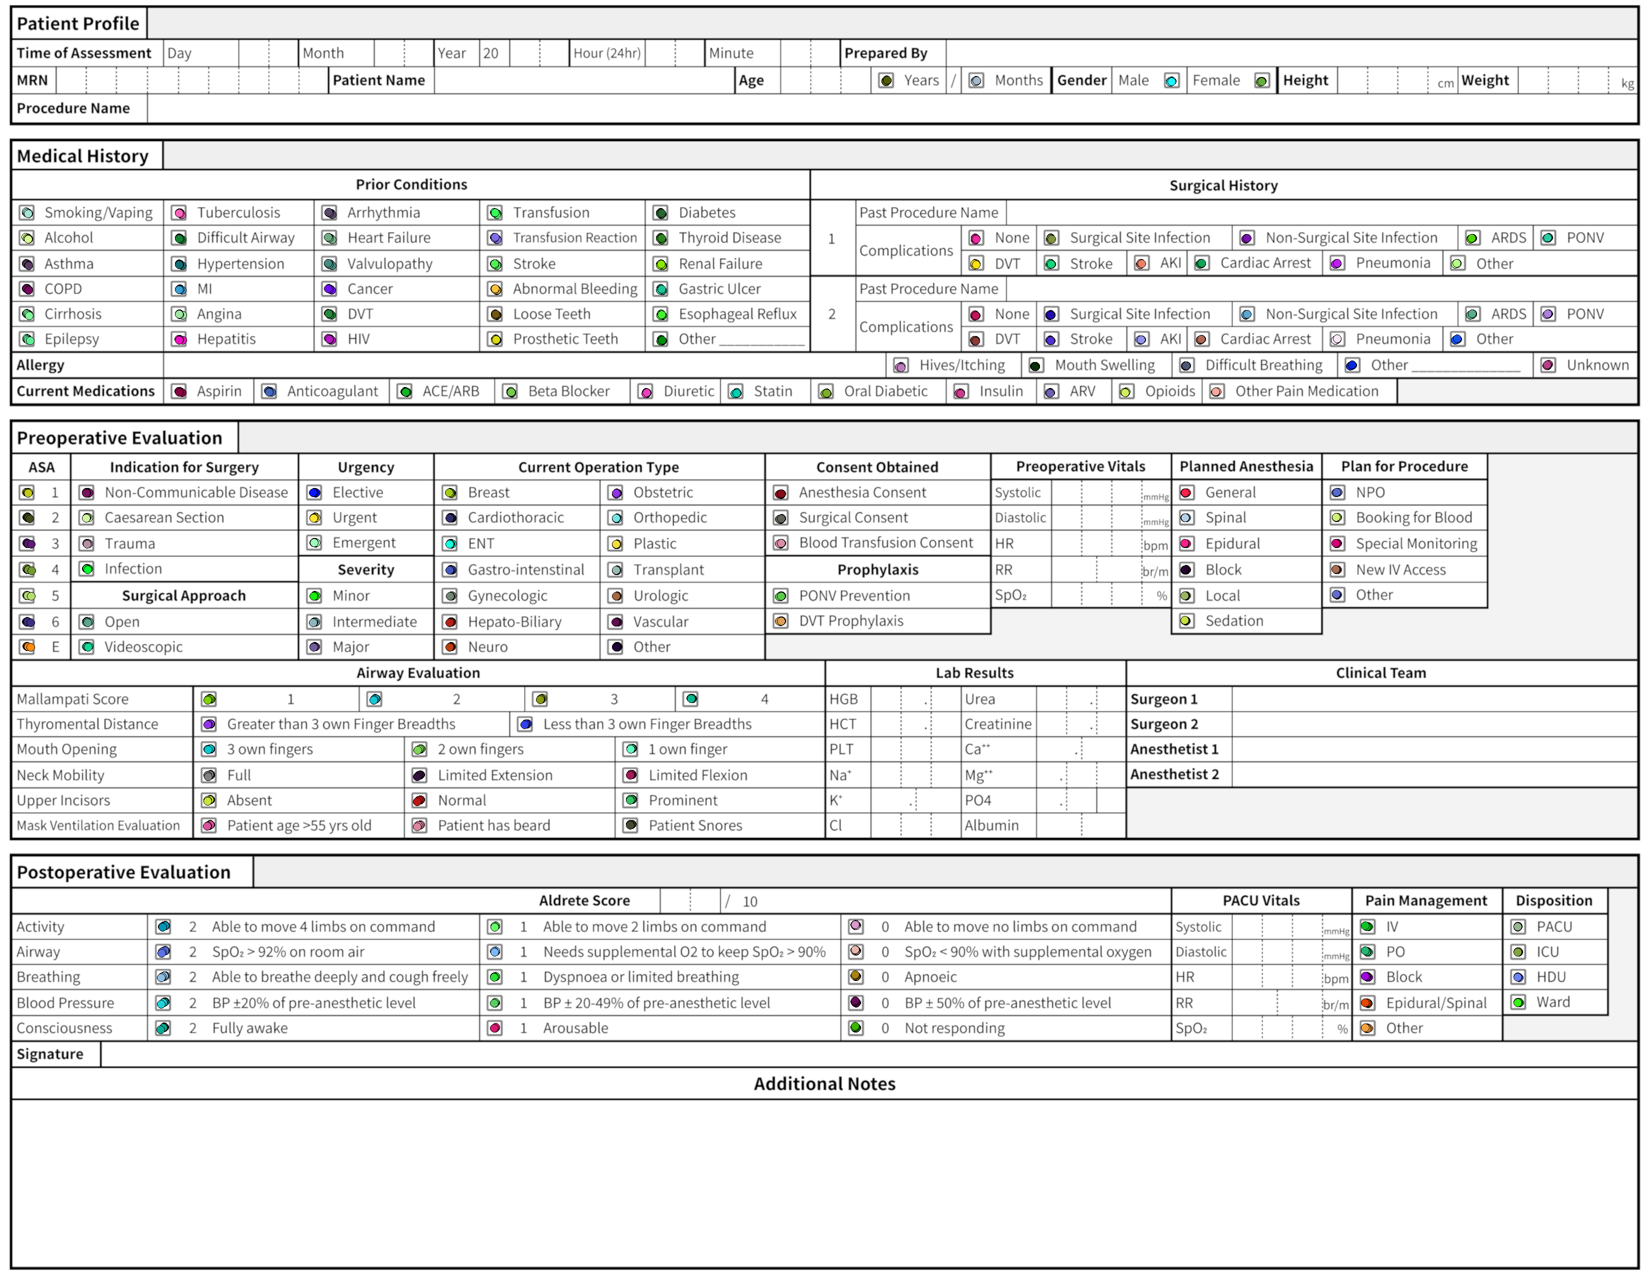

In [31]:
all_checkboxes_list = [item for sublist in [v for v in remapped_checkboxes.values()] for item in sublist]
checkbox_names = list(set([bb.category for bb in all_checkboxes_list]))
checkbox_name_to_color_map = {name:generate_color() for name in checkbox_names}

WIDTH, HEIGHT = 3300, 2250
im = Image.open(data_path/"unified_intraoperative_preoperative_flowsheet_v1_1_back.png")
WIDTH, HEIGHT = im.size
draw = ImageDraw.Draw(im)
POINT_SIZE = 8
for checkbox in all_checkboxes_list:
    x, y = checkbox.center
    x, y = x*WIDTH, y*HEIGHT
    draw.ellipse(
        (x-POINT_SIZE, y-POINT_SIZE, x+POINT_SIZE, y+POINT_SIZE),
        fill=checkbox_name_to_color_map[checkbox.category],
        outline="black"
    )
im.resize((WIDTH//2, HEIGHT//2))

In [32]:
checkbox_clusterer = KMeans(n_clusters=len(singleton_landmark_names), n_init="auto", random_state=0).fit(np.array([ckbx.center for ckbx in all_checkboxes_list]))

In [33]:
name_to_cluster_id_map = {
    v:k
    for (k, v) in list(set(
        sorted(
            [
                (cluster, box.category) 
                for (cluster, box) in list(zip(checkbox_clusterer.labels_.tolist(), all_checkboxes_list))
            ], key=lambda l: l[0]
        )
    ))
}
cluster_id_to_name_map = {v:k for (k, v) in name_to_cluster_id_map.items()}

In [34]:
category_to_boxes_map = {
    category:list(filter(lambda ckbx: ckbx.category==category, all_checkboxes_list))
    for category in list(set(c.category for c in all_checkboxes_list))
}
centers = {
    category:[box.center for box in category_boxes]
    for (category, category_boxes) in category_to_boxes_map.items()
}
preop_postop_centroids = {
    category:(np.mean([c[0] for c in centers]), np.mean([c[1] for c in centers]))
    for (category, centers) in centers.items()
}

In [35]:
for box in tqdm(all_checkboxes_list):
    prediction = checkbox_clusterer.predict([np.array(box.center)])
    true = name_to_cluster_id_map[box.category]
    if prediction != true:
        print("ERROR")
        print(box.category)
        print(f"Predicted: {prediction[0]}")
        print(f"True: {true}")

100%|██████████| 3097/3097 [02:50<00:00, 18.17it/s]


Dumping centroids to JSON

In [36]:
with open("intraop_centroids.json", 'w') as f:
    f.write(json.dumps(intraop_centroids))
with open("preop_postop_centroids.json", 'w') as f:
    f.write(json.dumps(preop_postop_centroids))

## 5 - Proposed Implementation

### 5.0 - Implementation

In this section, a few functions that could go into the main program are written.

In [121]:
# filepath consts will be changed in the real implementation.
FILEPATH_TO_INTRAOP_CENTROIDS = "intraop_centroids.json"
FILEPATH_TO_PREOP_POSTOP_CENTROIDS = "preop_postop_centroids.json"
INTRAOP_CENTROIDS = json.load(open(FILEPATH_TO_INTRAOP_CENTROIDS, 'r'))
PREOP_POSTOP_CENTROIDS = json.load(open(FILEPATH_TO_PREOP_POSTOP_CENTROIDS, 'r'))


def find_checkbox_names(
    checkboxes: List[BoundingBox],
    centroids: Dict[str, Tuple[float, float]],
    threshold: float=0.025,
) -> Dict[str, str]:
    """Finds the names of checkboxes.

    The checkboxes must be the locations after image registration, or else they will 
    be incorrect due to the naive nature of this solution, which is to merely find
    the closest checkbox based on the centroid of a sample of 10 ground-truth
    checkboxes.
    
    Args:
        checkboxes (List[BoundingBox]):
            The checkboxes to classify. The 'category' attribute should be 'checked'
            or 'unchecked'.
        centroids (Dict[str, Tuple[float, float]]):
            The centroids of a sample of 10 checkboxes.
        threshold (float):
            The threshold that determines how far a centroid can be before it 
            is totally ruled out. If all checkbox centroids are more than the
            threshold away, there is no associated name for that checkbox.
            Defaults to 2.5% of the image's width and height.

    Returns:
        A dictionary that maps the name of the checkbox to 'checked' or 'unchecked'.
    """
    def distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
        """Computes euclidean distance."""
        return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

    checkbox_values: Dict[str, str] = dict()
    for ckbx in checkboxes:
        distance_to_all_centroids: Dict[str, float] = {
            name:distance(ckbx.center, centroid)
            for (name, centroid) in centroids.items()
        }
        
        checkbox_too_far_from_any_centroid: bool = all(
            [dist > threshold for dist in list(distance_to_all_centroids.values())]
        )
        if checkbox_too_far_from_any_centroid:
            continue
        
        closest_checkbox_centroid: str = min(
            distance_to_all_centroids, 
            key=distance_to_all_centroids.get
        )
        checkbox_values[closest_checkbox_centroid] = ckbx.category

    return checkbox_values


def find_interaoperative_checkbox_names(
    intraoperative_checkboxes: List[BoundingBox], 
    threshold: float=0.025
) -> Dict[str, str]:
    """Finds the names of intraoperative checkboxes."""
    return find_checkbox_names(
        intraoperative_checkboxes, 
        INTRAOP_CENTROIDS, 
        threshold
    )


def find_preoperative_checkbox_names(
    preoperative_checkboxes: List[BoundingBox], 
    threshold: float=0.025
) -> Dict[str, str]:
    """Finds the names of preoperative checkboxes."""
    return find_checkbox_names(
        preoperative_checkboxes, 
        PREOP_POSTOP_CENTROIDS, 
        threshold
    )

### 5.1 - Intraoperative Demo of the Implementation

In [122]:
checkbox_classification_map = []
ckbx_to_col_map = {"No box": (128, 128, 128)}
generate_rgb_color = lambda: tuple(np.random.randint(low=0, high=255, size=3).tolist())
NEW_IM_WIDTH, NEW_IM_HEIGHT = 800, 600


for y in tqdm(np.arange(0, 1, 1/NEW_IM_HEIGHT)):
    new_checkbox_classification_row = []
    for x in np.arange(0, 1, 1/NEW_IM_WIDTH):
        bb_map = find_interaoperative_checkbox_names([BoundingBox('test', x-1, y-1, x+1, y+1)])
        bb_map = {v:k for (k, v) in bb_map.items()}
        bb = bb_map.get('test') or 'No box'
        new_checkbox_classification_row.append(bb)
        if bb not in ckbx_to_col_map.keys():
            ckbx_to_col_map[bb] = generate_rgb_color()
    checkbox_classification_map.append(new_checkbox_classification_row)

100%|██████████| 600/600 [00:39<00:00, 15.10it/s]


In [123]:
flatten = lambda l: [item for sublist in l for item in sublist]
checkbox_classification_color_map = [[ckbx_to_col_map[item] for item in row] for row in checkbox_classification_map]

In [124]:
foreground_im = Image.new("RGBA", (NEW_IM_WIDTH, NEW_IM_HEIGHT))
foreground_im.putdata([tuple(list(tup)+[200]) for tup in flatten(checkbox_classification_color_map)])

background_im = Image.open(data_path/"unified_intraoperative_preoperative_flowsheet_v1_1_front.png")
background_im = background_im.convert("RGBA")
background_im = background_im.resize((NEW_IM_WIDTH, NEW_IM_HEIGHT))
background_im.paste(foreground_im, (0, 0), foreground_im)

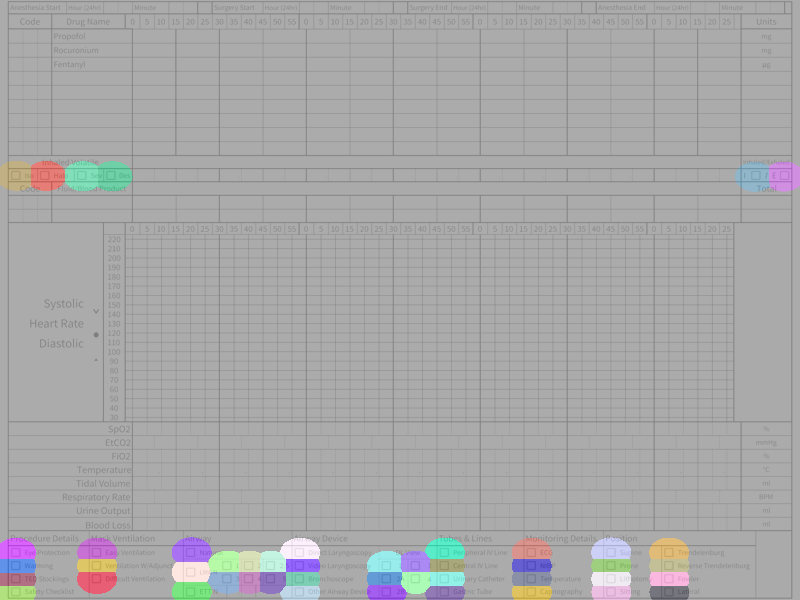

In [125]:
background_im

The grey space corresponds to points which would not be associated to a checkbox, and the colored space corresponds to the points which would be associated to a checkbox.  

### 5.2 - Preoperative/Postoperative Demo of the Implementation

In [126]:
checkbox_classification_map = []
ckbx_to_col_map = {"No box": (128, 128, 128)}
generate_rgb_color = lambda: tuple(np.random.randint(low=0, high=255, size=3).tolist())
NEW_IM_WIDTH, NEW_IM_HEIGHT = 800, 600


for y in tqdm(np.arange(0, 1, 1/NEW_IM_HEIGHT)):
    new_checkbox_classification_row = []
    for x in np.arange(0, 1, 1/NEW_IM_WIDTH):
        bb_map = find_preoperative_checkbox_names([BoundingBox('test', x-1, y-1, x+1, y+1)])
        bb_map = {v:k for (k, v) in bb_map.items()}
        bb = bb_map.get('test') or 'No box'
        new_checkbox_classification_row.append(bb)
        if bb not in ckbx_to_col_map.keys():
            ckbx_to_col_map[bb] = generate_rgb_color()
    checkbox_classification_map.append(new_checkbox_classification_row)

100%|██████████| 600/600 [02:13<00:00,  4.50it/s]


In [127]:
flatten = lambda l: [item for sublist in l for item in sublist]
checkbox_classification_color_map = [[ckbx_to_col_map[item] for item in row] for row in checkbox_classification_map]

In [128]:
foreground_im = Image.new("RGBA", (NEW_IM_WIDTH, NEW_IM_HEIGHT))
foreground_im.putdata([tuple(list(tup)+[200]) for tup in flatten(checkbox_classification_color_map)])

background_im = Image.open(data_path/"unified_intraoperative_preoperative_flowsheet_v1_1_back.png")
background_im = background_im.convert("RGBA")
background_im = background_im.resize((NEW_IM_WIDTH, NEW_IM_HEIGHT))
background_im.paste(foreground_im, (0, 0), foreground_im)

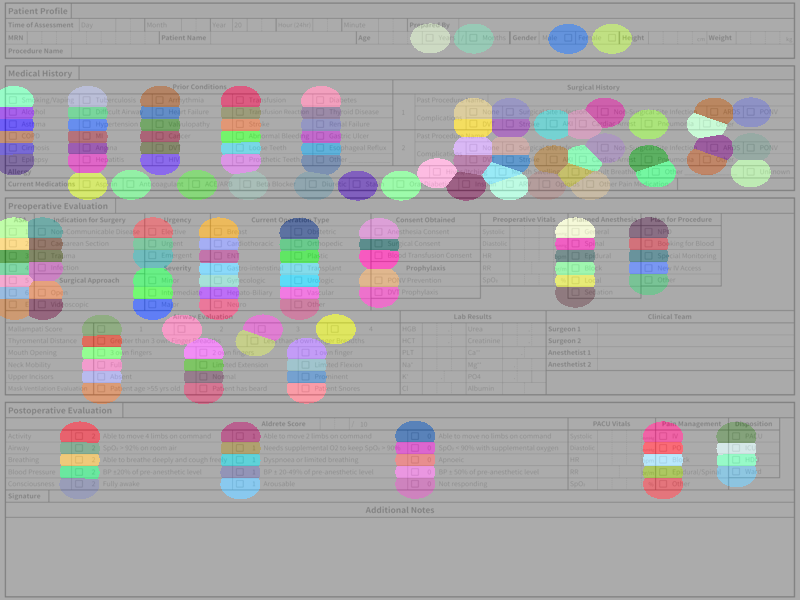

In [129]:
background_im

The grey space corresponds to points which would not be associated to a checkbox, and the colored space corresponds to the points which would be associated to a checkbox.  